I am referring: https://blog.keras.io/building-autoencoders-in-keras.html

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# os.system(r'tensorboard --logdir=/tmp/autoencoder &')
model_save_path = r'../models/cnn_hitansh.h5'
source_size = 500

input_img = Input(shape=(source_size, source_size, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [4]:
# Data Preparation
# We are resizing the images as square, with padding

def resize_with_padding(image, desired_size = 500):
    im=image
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im

x_train, x_test = [], []

PATH_TO_TEST_IMAGES_DIR = r'../data/train/XR_HAND_PHOTOSHOP/'
ALL_IMAGE_PATHS = []

for r, d, f in os.walk(PATH_TO_TEST_IMAGES_DIR):
    for file in f:
        if '.png' in file:
            # os.remove(os.path.join(r,file))
            ALL_IMAGE_PATHS.append(os.path.join(r, file))

# taking num_train images for training, num_test images for testing
num_train = 100
num_test = 10

for i in ALL_IMAGE_PATHS[:num_train]:
    img = cv2.imread(i, 0)
    x_train.append(resize_with_padding(img, desired_size = source_size))

for i in ALL_IMAGE_PATHS[num_train:num_train + num_test]:
    img = cv2.imread(i, 0)
    x_test.append(resize_with_padding(img, desired_size = source_size))

x_train = np.reshape(x_train, (len(x_train), source_size, source_size, 1))
x_test = np.reshape(x_test, (len(x_test), source_size, source_size, 1))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [7]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save(model_save_path)

Train on 100 samples, validate on 10 samples
Epoch 1/3
100/100 [==============================] - 40s 397ms/step - loss: 0.6277 - val_loss: 0.3765
Epoch 2/3
100/100 [==============================] - 39s 387ms/step - loss: 0.2354 - val_loss: 0.1957
Epoch 3/3
100/100 [==============================] - 40s 396ms/step - loss: 0.1643 - val_loss: 0.1755


In [2]:
autoencoder = load_model(model_save_path)

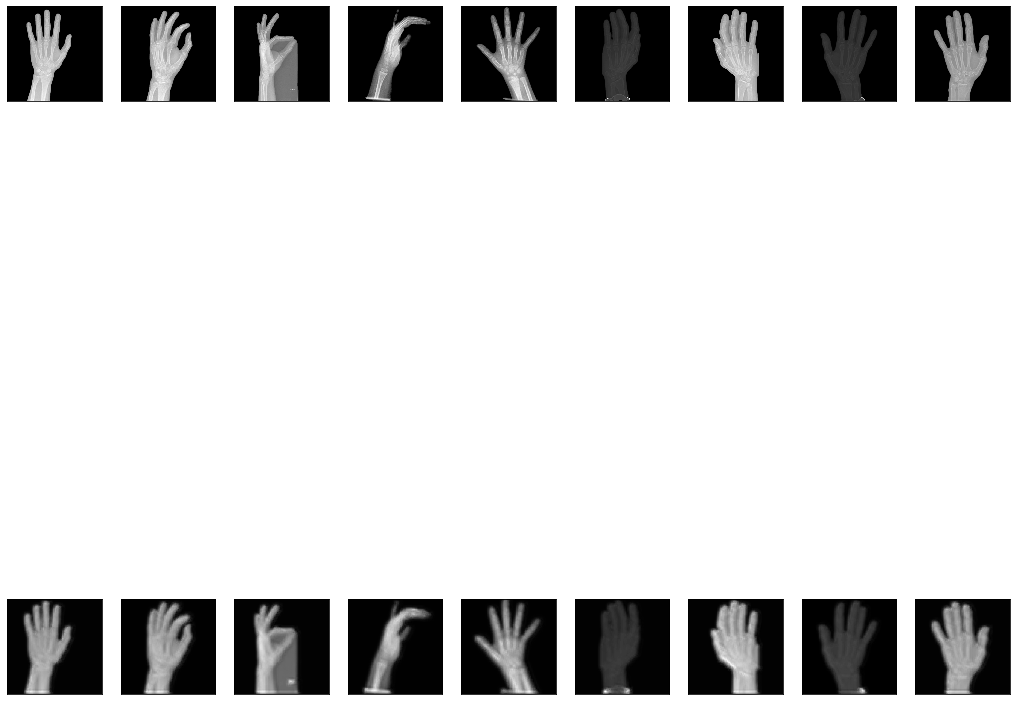

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 20))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(source_size, source_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(source_size, source_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

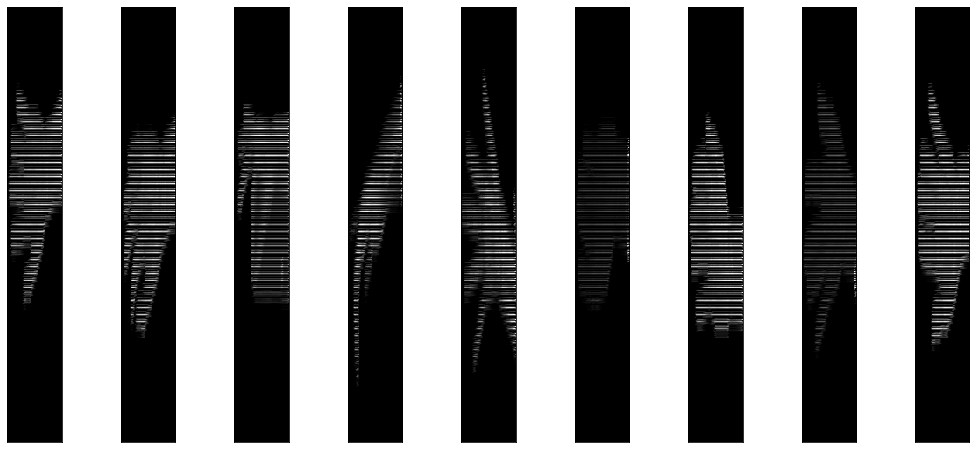

In [6]:
#Model = load_model(r'../models/cnn_hitansh.h5')

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

encoded_shape = encoded_imgs[0].shape

n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(encoded_shape[0], encoded_shape[1] * encoded_shape[2]).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()